In [1]:
# # install packages that will be used in this notebook

# !pip install numpy
# !pip install matplotlib
# !pip install tensorflow
# !pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
# !pip install transformers
# !pip install sklearn

In [2]:
# import required packages

import string
import re
import random
import numpy as np

import os

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

#!pip install --upgrade tensorflow
#!pip install --upgrade tensorflow-gpu

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# provide model name here (bert-small, bert-medium, bert-base, ocamlbert-large, or codebert)

model = input("Please specify the model name:")
model_name = model

Please specify the model name:bert-small


In [4]:
# provide task name here (14to15 or 15to14)

task = input("Please specify the task:")

Please specify the task:14to15


In [5]:
# define functions used for data preprocessing

def proccessing1(s, err = 'type error'):
    sl = s.splitlines()
    l_len = []
    prog = ''
    for i in sl:
        if "(*" in i:
            break
        l_len.append(len(i))
        prog += i
    start = 0
    end = 0
    for i in range(len(sl)):
        if err in sl[i]:
            start = i
    cut = sl[start+1:]
    for i in range(len(cut)):
        if '*)' in cut[i]:
            end = i
            break
    cut_s = cut[:end]
    lidx = []
    for span in cut_s:
        sp = re.findall(r'\d+', span)
        span_ = [int(d) for d in sp]
        row1, col1, row2, col2 = span_
        s = convert_idx((row1, col1),l_len)
        e = convert_idx((row2, col2),l_len)
        lidx.append([s,e])
    merged = merge_intervals(lidx)
    for m in merged:
        m[0] += 1
        m[1] += 1
        
    return prog, merged
    


def proccessing2(s, err = 'changed spans'):
    sl = s.splitlines()
    l_len = []
    prog = ''
    for i in sl:
        if "(*" in i:
            break
        l_len.append(len(i))
        prog += i
    start = 0
    end = 0
    for i in range(len(sl)):
        if err in sl[i]:
            start = i
    cut = sl[start+1:]
    for i in range(len(cut)):
        if '*)' in cut[i]:
            end = i
            break
    cut_s = cut[:end]
    lidx = []
    for span in cut_s:
        sp = re.findall(r'\d+', span)
        span_ = [int(d) for d in sp]
        row1, col1, row2, col2 = span_
        s = convert_idx((row1, col1),l_len)
        e = convert_idx((row2, col2),l_len)
        lidx.append([s,e])
    merged = merge_intervals(lidx)
    for m in merged:
        m[0] += 1
        m[1] += 1
    return prog, merged

def proccessing(s):
    prog, error = proccessing1(s, err = 'type error')
    prog, fix = proccessing2(s, err = 'changed spans')
    return prog, error, fix


def convert_idx(t,l):
    r,c = t
    idx = sum(l[:r-1]) + c-1
    return idx
    
    
def merge_intervals(temp_tuple):
    temp_tuple.sort(key=lambda interval: interval[0])
    merged = [temp_tuple[0]]
    for current in temp_tuple:
        previous = merged[-1]
        if current[0] <= previous[1]:
            previous[1] = max(previous[1], current[1])
        else:
            merged.append(current)
    return merged


def merge(intervals):
    starts = intervals[:,0]
    ends = np.maximum.accumulate(intervals[:,1])
    valid = np.zeros(len(intervals) + 1, dtype=np.bool)
    valid[0] = True
    valid[-1] = True
    valid[1:-1] = starts[1:] >= ends[:-1]
    return np.vstack((starts[:][valid[:-1]], ends[:][valid[1:]])).T

def word_filter0(w):
    ins = []
    if w[-1] == 't' and w[-2] == 'e' and w[-3] == 't':
        ins.append(w[:-3])
        ins.append('let')
    else:
        ins = [w]
    return ins

def word_filter1(w):
    # print(w)
    ins = []
    if len(w) >= 2:
        if w != '':
            if w[0] == '(':
                ins += ['(']
                if w[1] == '(':
                    ins += word_filter1(w[1:])
                else:
                    ins += [w[1:]]
            else:
                ins = [w]
        # if w[-1] == ')':
        #     ins += [')']
        #     if w[-2] == ')':
        #         ins += word_filter(w[:-1])
        #     else:
        #         ins += [w[:-1]]
        else:
            ins = [w]
    else:
        ins = [w]
    return ins


def word_filter2(w):
    def word_f2(w):
        ins = []
        if len(w) >= 2:
            if w[-1] == ')':
                ins += [')']
                if w[-2] == ')':
                    ins += word_f2(w[:-1])
                else:
                    ins += [w[:-1]]
        else:
            ins = [w]
        return ins
    if w != '':
        if w[-1] == ')': 
            ins = word_f2(w)[::-1]
        else:
            ins = [w]
    else:
        ins = [w]
    return ins


def word_filter3(w):
    ins = []
    if w[-1] == ';' and w[-2] == ';':
        ins.append(w[:-2])
        ins.append(';;')
    else:
        ins = [w]
    return ins




def filter_middle(w):
    ins = []
    if ',' in w:
        i = w.index(',')
        ins.append(w[:i])
        ins.append(',')
        ins.append(w[i+1:])
        return ins
    if '::' in w:
        i = w.index(':')
        ins.append(w[:i])
        ins.append('::')
        ins.append(w[i+2:])
        return ins
    if ';;' in w:
        i = w.index(';')
        ins.append(w[:i])
        ins.append(';;')
        ins.append(w[i+2:])
        return ins
    else:
        return [w]
    
# def filter_semicolon(w):
#     ins = []
#     for i in range(w):
                


def filter0(words):
    filtered = []
    for w in words:
        filtered += filter_middle(w)
    return filtered


def filter1(words):
    filtered = []
    for w in words:
        filtered += word_filter1(w)
    return filtered
    
def filter2(words):
    filtered = []
    for w in words:
        filtered += word_filter2(w)
    return filtered



def filter_(words):
    return filter2(filter1(filter0(words)))


def get_words(prog, merged):
    parts = []
    tracker = []
    sp = 0
    for i in range(len(merged)):
        tup = merged[i]
        parts.append(prog[sp:tup[0]])
        tracker.append(0)
        parts.append(prog[tup[0]:tup[1]])
        tracker.append(1)
        sp = tup[1]
    parts.append(prog[sp:])
    tracker.append(0)
    
    words = []
    label = []
    for i in range(len(parts)):
        # ps = filter(parts[i])
        ps = parts[i]
        wo = re.split('\s+', ps)
        # re.split('\s+', s)
        word = filter_(wo)
        words += word
        if tracker[i] == 0:
            label += [0.0 for w in range(len(word))]
        if tracker[i] == 1:
            label += [1.0 for w in range(len(word))]
            
    
    words_ = []
    label_ = []        
    for i in range(len(words)):
        if '' != words[i]:
            words_.append(words[i])
            label_.append(label[i])
            
    return words_,label_


def intersecc(error,fix):
    ress = []
    for e in error:
        for f in fix:
            if f[0] >= e[0] and e[1] >= f[0] and f[1] >= e[1]:
                ress.append([f[0],e[1]])
            elif e[0] >= f[0] and f[1] >= e[1]:
                ress.append([e[0],e[1]])
            elif e[0] >= f[0] and f[1] >= e[0] and e[1]>=f[1]:
                ress.append([e[0],f[1]])
            elif f[0] >= e[0] and f[1] <= e[1]:
                ress.append([f[0],f[1]])
            else:
                pass
    return ress

In [6]:
names1 = []
train1 = []
label1 = []

train2 = []
label2 = []
names2 = []

In [7]:
# unzip input data files, please make sure the archive.zip is at the same directory as this notebook

import zipfile
with zipfile.ZipFile('./archive.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [8]:
# data preprocessing for running in local environment
# might need to change the data_path string according to where the zipped out files are at

data_path = './Data'

path = data_path + "/sp14"
try:
    for filename in os.listdir(path):
        if '.ml' not in filename:
            continue
        with open(os.path.join(path, filename), 'r') as f:
            s = f.read()
            prog, error, fix = proccessing(s)
            ins = intersecc(error,fix)
            words_,label_ = get_words(prog, ins)
            names1.append(filename)
            train1.append(words_)
            label1.append(label_)
            f.close()
except:
    pass
       
    
path = data_path + "/fa15"

try:
    for filename in os.listdir(path):
        if '.ml' not in filename:
            continue
        with open(os.path.join(path, filename), 'r') as f:
            s = f.read()
            prog, error, fix = proccessing(s)
            ins = intersecc(error,fix)
            words_,label_ = get_words(prog, ins)
            names2.append(filename)
            train2.append(words_)
            label2.append(label_)
            f.close()      
except:
    pass

In [9]:
# data preprocessing for running on kaggle

data_path = '../input/ocamlerrordata/Data'

path = data_path + "/sp14"
try:
    for filename in os.listdir(path):
        if '.ml' not in filename:
            continue
        with open(os.path.join(path, filename), 'r') as f:
            s = f.read()
            prog, error, fix = proccessing(s)
            ins = intersecc(error,fix)
            words_,label_ = get_words(prog, ins)
            names1.append(filename)
            train1.append(words_)
            label1.append(label_)
            f.close()
except:
    pass
       
    
path = data_path + "/fa15"

try:
    for filename in os.listdir(path):
        if '.ml' not in filename:
            continue
        with open(os.path.join(path, filename), 'r') as f:
            s = f.read()
            prog, error, fix = proccessing(s)
            ins = intersecc(error,fix)
            words_,label_ = get_words(prog, ins)
            names2.append(filename)
            train2.append(words_)
            label2.append(label_)
            f.close()      
except:
    pass

In [10]:
import torch
torch.cuda.is_available()

True

In [11]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [12]:
# activate GPU as an accelerator

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig
import sklearn
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

MAX_LEN = 250
bs = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'GeForce GTX 1650'

In [13]:
# load tokenizer based on the model name provided above

from transformers import BertTokenizer, BertConfig, RobertaTokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

#tokenizer = BertTokenizer.from_pretrained('bert-large-cased', do_lower_case=False)


#tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-small', do_lower_case=False)

if model == 'bert-small':
    tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-small', do_lower_case=False)
elif model == 'bert-base':
    tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
elif model == 'ocamlbert-large':
    tokenizer = BertTokenizer.from_pretrained('bert-large-cased', do_lower_case=False)
elif model == 'codebert':
    tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base", do_lower_case=False)
elif model == 'bert-medium':
    tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-medium', do_lower_case=False)
    
print(model)
print(tokenizer)


bert-small
PreTrainedTokenizer(name_or_path='prajjwal1/bert-small', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


In [14]:
# tokenize words using the tokenizer loaded above

def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


tokenized_texts_and_labels1 = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(train1, label1)
]

tokenized_texts_and_labels2 = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(train2, label2)
]




tokenized_texts1 = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels1]
labels1 = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels1]

tokenized_texts2 = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels2]
labels2 = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels2]


input_ids1 = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts1],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")


input_ids2 = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts2],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

tag_values1 = list(set(label1[0]))
tag_values1.append("PAD")
tag2idx1 = {t: i for i, t in enumerate(tag_values1)}

tags1 = pad_sequences([[tag2idx1.get(l) for l in lab] for lab in labels1],
                     maxlen=MAX_LEN, value=tag2idx1["PAD"], padding="post",
                     dtype="long", truncating="post")



tag_values2 = list(set(label2[0]))
tag_values2.append("PAD")
tag2idx2 = {t: i for i, t in enumerate(tag_values2)}

tags2 = pad_sequences([[tag2idx2.get(l) for l in lab] for lab in labels2],
                     maxlen=MAX_LEN, value=tag2idx2["PAD"], padding="post",
                     dtype="long", truncating="post")

attention_masks1 = [[float(i != 0.0) for i in ii] for ii in input_ids1]

attention_masks2 = [[float(i != 0.0) for i in ii] for ii in input_ids2]

In [15]:
# divide train and valid datasets based on the task provided before


if task == '14to15':
    tr_inputs = torch.tensor(input_ids1)
    val_inputs = torch.tensor(input_ids2)
    tr_tags = torch.tensor(tags1)
    val_tags = torch.tensor(tags2)
    tr_masks = torch.tensor(attention_masks1)
    val_masks = torch.tensor(attention_masks2)
elif task == '15to14':
    tr_inputs = torch.tensor(input_ids2)
    val_inputs = torch.tensor(input_ids1)
    tr_tags = torch.tensor(tags2)
    val_tags = torch.tensor(tags1)
    tr_masks = torch.tensor(attention_masks2)
    val_masks = torch.tensor(attention_masks1)

# if task == '14to14':
#     tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids1, tags1,
#                                                             random_state=2018, test_size=0.1)
#     tr_masks, val_masks, _, _ = train_test_split(attention_masks1, input_ids1,
#                                                  random_state=2018, test_size=0.1)
#     tr_inputs = torch.tensor(tr_inputs)
#     val_inputs = torch.tensor(val_inputs)
#     tr_tags = torch.tensor(tr_tags)
#     val_tags = torch.tensor(val_tags)
#     tr_masks = torch.tensor(tr_masks)
#     val_masks = torch.tensor(val_masks)
# elif task == '15to15':
#     tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids2, tags2,
#                                                             random_state=2018, test_size=0.1)
#     tr_masks, val_masks, _, _ = train_test_split(attention_masks2, input_ids2,
#                                                  random_state=2018, test_size=0.1)
#     tr_inputs = torch.tensor(tr_inputs)
#     val_inputs = torch.tensor(val_inputs)
#     tr_tags = torch.tensor(tr_tags)
#     val_tags = torch.tensor(val_tags)
#     tr_masks = torch.tensor(tr_masks)
#     val_masks = torch.tensor(val_masks)
# elif task == '14to15':
#     tr_inputs = torch.tensor(input_ids1)
#     val_inputs = torch.tensor(input_ids2)
#     tr_tags = torch.tensor(tags1)
#     val_tags = torch.tensor(tags2)
#     tr_masks = torch.tensor(attention_masks1)
#     val_masks = torch.tensor(attention_masks2)
# elif task == '15to14':
#     tr_inputs = torch.tensor(input_ids2)
#     val_inputs = torch.tensor(input_ids1)
#     tr_tags = torch.tensor(tags2)
#     val_tags = torch.tensor(tags1)
#     tr_masks = torch.tensor(attention_masks2)
#     val_masks = torch.tensor(attention_masks1)
    
    


In [16]:
# Task1: sp14 -> sp14
# tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids1, tags1,
#                                                             random_state=2018, test_size=0.1)
# tr_masks, val_masks, _, _ = train_test_split(attention_masks1, input_ids1,
#                                              random_state=2018, test_size=0.1)
# tr_inputs = torch.tensor(tr_inputs)
# val_inputs = torch.tensor(val_inputs)
# tr_tags = torch.tensor(tr_tags)
# val_tags = torch.tensor(val_tags)
# tr_masks = torch.tensor(tr_masks)
# val_masks = torch.tensor(val_masks)




# Task2: fa15 -> fa15
# tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids2, tags2,
#                                                             random_state=2018, test_size=0.1)
# tr_masks, val_masks, _, _ = train_test_split(attention_masks2, input_ids2,
#                                              random_state=2018, test_size=0.1)
# tr_inputs = torch.tensor(tr_inputs)
# val_inputs = torch.tensor(val_inputs)
# tr_tags = torch.tensor(tr_tags)
# val_tags = torch.tensor(val_tags)
# tr_masks = torch.tensor(tr_masks)
# val_masks = torch.tensor(val_masks)


# Task3: sp14->fa15
# tr_inputs = torch.tensor(input_ids1)
# val_inputs = torch.tensor(input_ids2)
# tr_tags = torch.tensor(tags1)
# val_tags = torch.tensor(tags2)
# tr_masks = torch.tensor(attention_masks1)
# val_masks = torch.tensor(attention_masks2)

# Task4: fa15->sp14
# tr_inputs = torch.tensor(input_ids2)
# val_inputs = torch.tensor(input_ids1)
# tr_tags = torch.tensor(tags2)
# val_tags = torch.tensor(tags1)
# tr_masks = torch.tensor(attention_masks2)
# val_masks = torch.tensor(attention_masks1)

In [17]:
# use dataloader to create datasets used for future model training and validating

train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [18]:
# load pre-trained model based on the model name provided before

import transformers
from transformers import BertForTokenClassification, AdamW, BertConfig, RobertaForTokenClassification

transformers.__version__

if model == 'bert-small' and task[0:2] == '14':
    model = BertForTokenClassification.from_pretrained('TianyuHan/bertsmall14',num_labels=len(tag2idx1),output_attentions = False,output_hidden_states = False)
elif model =='bert-small' and task[0:2] == '15':
    model = BertForTokenClassification.from_pretrained('TianyuHan/bertsmall15',num_labels=len(tag2idx1),output_attentions = False,output_hidden_states = False)
elif model == 'bert-base' and task[0:2] == '14':
    model = BertForTokenClassification.from_pretrained('TianyuHan/bertbase14',num_labels=len(tag2idx1),output_attentions = False,output_hidden_states = False)
elif model == 'bert-base' and task[0:2] == '15':
    model = BertForTokenClassification.from_pretrained('TianyuHan/bertbase15',num_labels=len(tag2idx1),output_attentions = False,output_hidden_states = False)
elif model == 'codebert' and task[0:2] == '14':
    model = RobertaForTokenClassification.from_pretrained(
         "AllenGeng/CodeBert14",
         num_labels=len(tag2idx1),
         output_attentions = False,
         output_hidden_states = False
    )
elif model == 'codebert' and task[0:2] == '15':
    model = RobertaForTokenClassification.from_pretrained(
         "AllenGeng/CodeBert15",
         num_labels=len(tag2idx1),
         output_attentions = False,
         output_hidden_states = False
    )
elif model == 'bert-medium' and task[0:2] == '14':
    model = BertForTokenClassification.from_pretrained('TianyuHan/bertmedium14',num_labels=len(tag2idx1),output_attentions = False,output_hidden_states = False)
elif model == 'bert-medium' and task[0:2] == '15':
    model = BertForTokenClassification.from_pretrained('TianyuHan/bertmedium15',num_labels=len(tag2idx1),output_attentions = False,output_hidden_states = False)
elif model == 'ocamlbert-large' and task[0:2] == '14':
    model = BertForTokenClassification.from_pretrained('TianyuHan/ocamlbertlarge14',num_labels=len(tag2idx1),output_attentions = False,output_hidden_states = False)
elif model == 'ocamlbert-large' and task[0:2] == '15':
    model = BertForTokenClassification.from_pretrained('TianyuHan/ocamlbertlarge15',num_labels=len(tag2idx1),output_attentions = False,output_hidden_states = False)


In [19]:
# model training and results printing

model.cuda();
# ========================================
#               Validation
# ========================================
# After the completion of each training epoch, measure our performance on
# our validation set.

# Put the model into evaluation mode
model.eval()
# Reset the validation loss for this epoch.
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
predictions , true_labels = [], []
for batch in valid_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients,
    # saving memory and speeding up validation
    with torch.no_grad():
        b_labels = b_labels.to(torch.int64) # This line is added since running locally with a different GPU requires it. Might need to delete if you are using a different GPU.
        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have not provided labels.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
    # Move logits and labels to CPU
    logits = outputs[1].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Calculate the accuracy for this batch of test sentences.
    eval_loss += outputs[0].mean().item()
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.extend(label_ids)

eval_loss = eval_loss / len(valid_dataloader)

pred = np.array(predictions)
y = np.array(true_labels)
pad_mask = np.array(true_labels)
pad_mask[pad_mask==0] = 1
pad_mask[pad_mask==2] = 0
pred = pred & pad_mask
y[y==2]=0

intersection = pred & y
union = pred | y
nonzero_intersection = torch.count_nonzero(torch.from_numpy(intersection), dim=1)
nonzero_union = torch.count_nonzero(torch.from_numpy(union), dim=1)
nonzero_intersection = torch.where(nonzero_union == 0, 1, nonzero_intersection)
nonzero_union[nonzero_union==0] = 1


acc = nonzero_intersection / nonzero_union

print("The final result is: " + str(torch.mean(acc).numpy()))

The final result is: 0.52288455


In [21]:
import torch


def acc_threshold(logits, threshold):
    softmax = torch.nn.Softmax(dim=1)
    prob = []
    for i in logits:
        logits_ = torch.tensor(i)
        prob.append(softmax(logits_))
    res = []
    for p in prob:
        gg = (p[:,1] >= threshold)*1
        res.append(gg.tolist())
    return res
            


def eval_(model,threshold):
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            b_labels = b_labels.to(torch.int64)  # This line is added since running locally with a different GPU requires it. Might need to delete if you are using a different GPU.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
    #    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        predictions.extend(acc_threshold(logits, threshold))
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
#     validation_loss_values.append(eval_loss)
#     print("Validation loss: {}".format(eval_loss))

    pred = np.array(predictions)
    y = np.array(true_labels)
    pad_mask = np.array(true_labels)
    pad_mask[pad_mask==0] = 1
    pad_mask[pad_mask==2] = 0
    pred = pred & pad_mask
    y[y==2]=0

    intersection = pred & y
    union = pred | y

    nonzero_intersection = torch.count_nonzero(torch.from_numpy(intersection), dim=1)
    nonzero_union = torch.count_nonzero(torch.from_numpy(union), dim=1)
    nonzero_intersection = torch.where(nonzero_union == 0, 1, nonzero_intersection)
    nonzero_union[nonzero_union==0] = 1
    acc = nonzero_intersection / nonzero_union
    return torch.mean(acc)



thel = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
# print(thel)



def eval_on_thel(model,thel):
    ress = []
    for i in thel:
        ress.append(eval_(model,i))
    return ress
accs = eval_on_thel(model,thel)

In [22]:
for i in range(10):
    print("When threshold equals to {}, model's diagnosis accuracy evaluates to {:.3f}%".format(thel[i],float(accs[i])*100))



When threshold equals to 0.0, model's diagnosis accuracy evaluates to 19.233%
When threshold equals to 0.1, model's diagnosis accuracy evaluates to 53.612%
When threshold equals to 0.2, model's diagnosis accuracy evaluates to 54.272%
When threshold equals to 0.3, model's diagnosis accuracy evaluates to 53.474%
When threshold equals to 0.4, model's diagnosis accuracy evaluates to 52.961%
When threshold equals to 0.5, model's diagnosis accuracy evaluates to 52.287%
When threshold equals to 0.6, model's diagnosis accuracy evaluates to 51.383%
When threshold equals to 0.7, model's diagnosis accuracy evaluates to 49.675%
When threshold equals to 0.8, model's diagnosis accuracy evaluates to 48.496%
When threshold equals to 0.9, model's diagnosis accuracy evaluates to 44.926%


<Figure size 432x288 with 0 Axes>

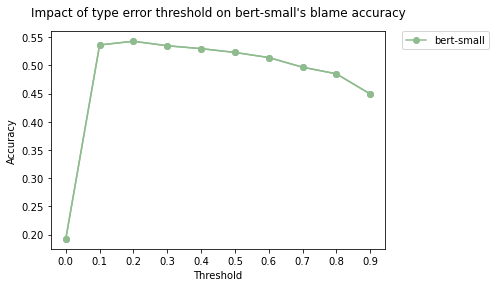

<Figure size 432x288 with 0 Axes>

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
from pickle import FALSE
from typing import Sized
import matplotlib.pylab as pylab

m_x = []
for i in range(10):
    m_x.append(i/10)
    accs[i] = float(accs[i])

plt.plot(m_x,accs, color="darkseagreen", marker="o", label=model_name)
plt.plot(m_x,accs, marker = "o",  color="darkseagreen")

plt.title("Impact of type error threshold on {}'s blame accuracy".format(model_name), pad = 15)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.xticks(m_x, m_x)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.grid(False)
plt.figure(figsize=(6,4))